In [ ]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "../data/processed/feature-engineer-dataset.csv"
df = pd.read_csv(path)

count    29090.000000
mean        13.339567
std         70.177207
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max       6288.000000
Name: transactionID, dtype: float64


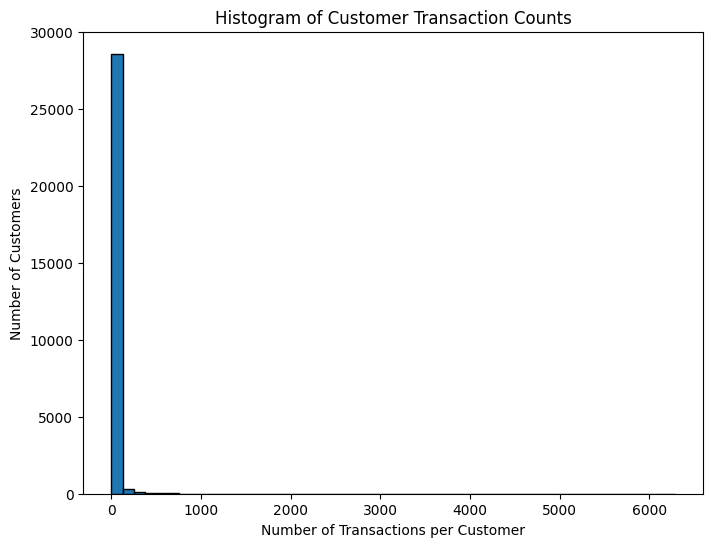

In [ ]:
# Count number of transactions per customer
txn_counts = df.groupby("customerID")["transactionID"].nunique()

# Print summary
print(txn_counts.describe())

# Plot histogram
plt.figure(figsize=(8,6))
plt.hist(txn_counts, bins=50, edgecolor='black')
plt.xlabel("Number of Transactions per Customer")
plt.ylabel("Number of Customers")
plt.title("Histogram of Customer Transaction Counts")
plt.show()


In [ ]:
# Count transactions per customer
txn_counts = df.groupby("customerID")["transactionID"].nunique()

# Attach transaction counts back to df
df_with_counts = df.merge(txn_counts.rename("n_txns"), on="customerID")

# Define thresholds
thresholds = [5, 10, 20]

summary = []
total_customers = df_with_counts["customerID"].nunique()
total_txns = len(df_with_counts)

for t in thresholds:
    subset = df_with_counts[df_with_counts["n_txns"] >= t]
    n_customers = subset["customerID"].nunique()
    n_txns = len(subset)

    summary.append({
        "Threshold": f"≥{t}",
        "Customers": n_customers,
        "Customers_%": n_customers / total_customers * 100,
        "Transactions": n_txns,
        "Transactions_%": n_txns / total_txns * 100
    })

summary_df = pd.DataFrame(summary)

print("Customer & Transaction Retention at Different Thresholds:")
print(summary_df.to_string(index=False))

Customer & Transaction Retention at Different Thresholds:
Threshold  Customers  Customers_%  Transactions  Transactions_%
       ≥5       9664    33.221038        343759       88.586721
      ≥10       5492    18.879340        316237       81.494300
      ≥20       3112    10.697834        284414       73.293510


In [ ]:
# ===============================
# Step 2. Filter customers with <5 transactions
# ===============================
txn_counts = df.groupby("customerID")["transactionID"].nunique()
valid_customers = txn_counts[txn_counts >= 5].index
df_filtered = df[df["customerID"].isin(valid_customers)].copy()

print("Original customers:", df["customerID"].nunique())
print("Filtered customers (≥5 txns):", df_filtered["customerID"].nunique())
print("Original transactions:", len(df))
print("Filtered transactions:", len(df_filtered))

Original customers: 29090
Filtered customers (≥5 txns): 9664
Original transactions: 388048
Filtered transactions: 343759


In [ ]:
# ===============================
# Step 3. Temporal train-test split function
# ===============================
def temporal_train_test_split(df, user_col="customerID", time_col="transaction_date", test_ratio=0.2):
    """
    Per-user temporal split: last ~20% transactions into test (≥1).
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])  # ensure datetime

    train_list, test_list = [], []

    for cust_id, group in df.groupby(user_col):
        group = group.sort_values(time_col)
        n = len(group)

        n_test = max(1, int(np.floor(test_ratio * n)))

        test_idx = group.tail(n_test).index
        train_idx = group.head(n - n_test).index

        train_list.append(df.loc[train_idx])
        test_list.append(df.loc[test_idx])

    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    return train_df, test_df


# ===============================
# Step 4. Apply the split
# ===============================
train_df, test_df = temporal_train_test_split(
    df_filtered,
    user_col="customerID",
    time_col="transaction_date",
    test_ratio=0.2
)

print("\nTrain size:", len(train_df))
print("Test size:", len(test_df))

# ===============================
# Step 5. Sanity checks
# ===============================
# Each customer's train + test = total
check = (
    train_df.groupby("customerID").size() + test_df.groupby("customerID").size()
).equals(df_filtered.groupby("customerID").size())
print("\nCheck per customer (train+test == total):", check)

# Distribution of test set size
test_sizes = test_df.groupby("customerID").size()
print("\nTest transactions per customer (min, max, mean):",
      test_sizes.min(), test_sizes.max(), test_sizes.mean())


Train size: 278385
Test size: 65374

Check per customer (train+test == total): True

Test transactions per customer (min, max, mean): 1 1257 6.764693708609271


In [ ]:
# check number of different types of investors
# mass, premium and professional are all individual investors
df_filtered.drop_duplicates(subset=['customerID'], keep='first')['customerType'].value_counts()

,count
customerType,
Mass,5887
Premium,3188
Professional,529
Inactive,43
Legal Entity,17


In [ ]:
# ===============================
# Step 6. Export to CSV
# ===============================
train_path = "/content/drive/MyDrive/NUSFintech/data/processed/train.csv"
test_path  = "/content/drive/MyDrive/NUSFintech/data/processed/test.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"\n✅ Train set saved to: {train_path}")
print(f"✅ Test set saved to:  {test_path}")



✅ Train set saved to: /content/drive/MyDrive/NUSFintech/data/processed/train.csv
✅ Test set saved to:  /content/drive/MyDrive/NUSFintech/data/processed/test.csv
